# Base de données répertoriant les indicateurs de délinquance et de criminalité (1996-2022 en France)

(NB : Les liens hypertextes présent dans ce markdown et les suivant renvoient aux sites internet sur lesquelles les tableaux de données ont été téléchargées et ne correspondent pas aux URL de téléchargement, l'exécution des cellules de code permet de télécharger automatiquement les jeu de données)

Nous avons récupéré, grâce à l'open data du ministère de l'intérieur ([ici](https://www.data.gouv.fr/fr/datasets/chiffres-departementaux-mensuels-relatifs-aux-crimes-et-delits-enregistres-par-les-services-de-police-et-de-gendarmerie-depuis-janvier-1996/)) les données relatives aux crimes et délit enregistrés dans chaque département et en France entre janvier 1996 et août 2022. Ce jeu de données a été produit successivement par le Ministère de l'Intérieur puis par le SSMSI depuis sa création en 2014. 

Issu directement des applications informatiques de gestion, il n'est pas retraité et reste assez brut. Entre autre, il ne nous donne accès qu'au nombre d'infractions (classées par type) par département, nous l'avons donc complété avec des données d'estimation de population pour obtenir des taux d'infractions plutôt que des chiffres bruts. Nous avons ensuite ajoutée à notre base de données d'indices de localisation pour nous permettre de réaliser des représentations géographiques dans notre partie de statistiques descriptives.

### Récupération et nettoyage des données du Ministère de l'Intérieur relative aux crimes et délits


In [2]:
import requests
import pandas as pd
import geopandas as gpd
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt


In [3]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
# URL de téléchargement du fichier
url = "https://static.data.gouv.fr/resources/chiffres-departementaux-mensuels-relatifs-aux-crimes-et-delits-enregistres-par-les-services-de-police-et-de-gendarmerie-depuis-janvier-1996/20221031-102847/tableaux-4001-ts.xlsx" 

# Dossier de destination pour enregistrer le fichier téléchargé
dossier_destination = "data_police"
os.makedirs(dossier_destination, exist_ok=True)

# Chemin du fichier téléchargé
fichier_telecharge = os.path.join(dossier_destination, "fichier.xlsx")

# Téléchargement du fichier
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_telecharge, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_telecharge)

# Chargement des onglets du fichier Excel en DataFrames
print("Chargement des onglets dans des DataFrames...")
data = pd.read_excel(fichier_telecharge, sheet_name=None)  # `sheet_name=None` charge tous les onglets

# Fusion des onglets dans un unique DataFrame avec une colonne pour identifier le département (ou la zone)
données_police = pd.concat(
    [df.assign(Zone=nom_onglet) for nom_onglet, df in data.items()],
    ignore_index=True
)

# Affichage du DataFrame combiné
print("\nDataFrame combiné avec tous les onglets :")
print(données_police)

'''
# Sauvegarde du DataFrame combiné dans un fichier Excel
excel_output_path = os.path.join(dossier_destination, "données police.xlsx")
données_police.to_excel(excel_output_path, index=False)

print(f"Le DataFrame combiné a été sauvegardé dans : {excel_output_path}")
'''

# Suppression du fichier téléchargé 
os.remove(fichier_telecharge)
print("Fichier téléchargé supprimé.")

Téléchargement en cours...


Téléchargement terminé: data_police/fichier.xlsx
Chargement des onglets dans des DataFrames...

DataFrame combiné avec tous les onglets :
       Index                                      libellé index  _2022_08  \
0          1             Règlements de compte entre malfaiteurs        14   
1          2       Homicides pour voler et à l'occasion de vols         2   
2          3                     Homicides pour d'autres motifs        88   
3          4  Tentatives d'homicides pour voler et à l'occas...        15   
4          5          Tentatives homicides pour d'autres motifs       315   
...      ...                                                ...       ...   
11658    103  Infractions à l'exercice d'une profession règl...         3   
11659    104  Infractions au droit de l'urbanisme et de la c...         2   
11660    105                                   Fraudes fiscales         0   
11661    106            Autres délits économiques et financiers         6   
11662    107   

On sépare notre premier jeu de données (données police) en deux pour obtenir une base de données départementale et une base nationale.


In [5]:
#Données pour la france entière
df_france_court = données_police[données_police['Zone'].isin(['France_Entière', 'France_Métro'])]

#Affichage
print("DataFrame la France entière:")
print(df_france_court)

'''
#Sauvegarde un fichier Excel
excel_output_path = os.path.join(dossier_destination, "données france court.xlsx")
df_france_court.to_excel(excel_output_path, index=False)

print(f"Le DataFrame combiné a été sauvegardé dans : {excel_output_path}")
'''

DataFrame la France entière:
     Index                                      libellé index  _2022_08  \
0        1             Règlements de compte entre malfaiteurs        14   
1        2       Homicides pour voler et à l'occasion de vols         2   
2        3                     Homicides pour d'autres motifs        88   
3        4  Tentatives d'homicides pour voler et à l'occas...        15   
4        5          Tentatives homicides pour d'autres motifs       315   
..     ...                                                ...       ...   
209    103  Infractions à l'exercice d'une profession règl...       130   
210    104  Infractions au droit de l'urbanisme et de la c...       328   
211    105                                   Fraudes fiscales        62   
212    106            Autres délits économiques et financiers      1168   
213    107                                      Autres délits     13941   

     _2022_07  _2022_06  _2022_05  _2022_04  _2022_03  _2022_02  _2022

'\n#Sauvegarde un fichier Excel\nexcel_output_path = os.path.join(dossier_destination, "données france court.xlsx")\ndf_france_court.to_excel(excel_output_path, index=False)\n\nprint(f"Le DataFrame combiné a été sauvegardé dans : {excel_output_path}")\n'

In [6]:
# Sélectionner les lignes où 'Onglet' n'est ni 'France_Entière' ni 'France_Métro'
df_dep_court = données_police[~données_police['Zone'].isin(['France_Entière', 'France_Métro'])]

# Affichage du dataframe obtenu
print("DataFrame sans France entière ni France Métro :")
print(df_dep_court)

'''
# Sauvegarde dans un fichier Excel
excel_output_path = os.path.join(dossier_destination, "données départements court.xlsx")
df_dep_court.to_excel(excel_output_path, index=False)

print(f"Le DataFrame combiné a été sauvegardé dans : {excel_output_path}")
'''


DataFrame sans France entière ni France Métro :
       Index                                      libellé index  _2022_08  \
214        1             Règlements de compte entre malfaiteurs         0   
215        2       Homicides pour voler et à l'occasion de vols         0   
216        3                     Homicides pour d'autres motifs         0   
217        4  Tentatives d'homicides pour voler et à l'occas...         0   
218        5          Tentatives homicides pour d'autres motifs         0   
...      ...                                                ...       ...   
11658    103  Infractions à l'exercice d'une profession règl...         3   
11659    104  Infractions au droit de l'urbanisme et de la c...         2   
11660    105                                   Fraudes fiscales         0   
11661    106            Autres délits économiques et financiers         6   
11662    107                                      Autres délits        66   

       _2022_07  _2022_06  

'\n# Sauvegarde dans un fichier Excel\nexcel_output_path = os.path.join(dossier_destination, "données départements court.xlsx")\ndf_dep_court.to_excel(excel_output_path, index=False)\n\nprint(f"Le DataFrame combiné a été sauvegardé dans : {excel_output_path}")\n'

Le format des tableaux de données actuel indique les dates sur une ligne (voir ci-dessous). 

| Index  | Libellé | Zone | _2022_08 | _2022_07 | ... | _1996_01 |
|-----------|----------|----------|----------|----------|----------|----------|
| Type 1    | Libellé  1 | France | Valeur 1 | Valeur 3 | Valeur 5 | Valeur 8 |
| Type 2    | Libellé  2 | France | Valeur 2 | Valeur 4 | Valeur 6 | Valeur 9 |

Nous préférions avoir une colonne indiquant les dates car il nous semblait plus simple de filtrer par date et d'ajouter de nouvelle colonnes d'information ainsi (exemple ci-dessous).

| Index | Libellé | Zone | Date |
|-------|---------|------|------|
| Type 1 | Libellé 1 | Zone a | _2022_08 |
| Type 2 | Libellé 2 | Zone a | _2022_08 |
| ... | ... | ... | ... |
| Type 1 | Libellé 1 | Zone f | _2012_05 |
| ... | ... | ... | ... |
| Type 34 | Libellé 34 | Zone z | _1996_01 |

Nous avons donc restructurer les deux tableaux de données (df_france_court et df_dep_court) en format long.


In [7]:
# Transformer le tableau (échelle nationale) en format "long"
df_france = df_france_court.melt(id_vars=['Index', 'libellé index', 'Zone'],  # Colonnes fixes
                  var_name='Date',  # Nom pour la colonne de dates
                  value_name='Nombre')  # Nom pour la colonne des valeurs

# Affichage
print(df_france)

'''
# Sauvegarde dans un fichier Excel
excel_output_path = os.path.join(dossier_destination, "données france.xlsx")
df_france.to_excel(excel_output_path, index=False)

print(f"Le DataFrame a été sauvegardé dans : {excel_output_path}")
'''

       Index                                      libellé index  \
0          1             Règlements de compte entre malfaiteurs   
1          2       Homicides pour voler et à l'occasion de vols   
2          3                     Homicides pour d'autres motifs   
3          4  Tentatives d'homicides pour voler et à l'occas...   
4          5          Tentatives homicides pour d'autres motifs   
...      ...                                                ...   
68475    103  Infractions à l'exercice d'une profession règl...   
68476    104  Infractions au droit de l'urbanisme et de la c...   
68477    105                                   Fraudes fiscales   
68478    106            Autres délits économiques et financiers   
68479    107                                      Autres délits   

                 Zone      Date  Nombre  
0      France_Entière  _2022_08    14.0  
1      France_Entière  _2022_08     2.0  
2      France_Entière  _2022_08    88.0  
3      France_Entière  _202

'\n# Sauvegarde dans un fichier Excel\nexcel_output_path = os.path.join(dossier_destination, "données france.xlsx")\ndf_france.to_excel(excel_output_path, index=False)\n\nprint(f"Le DataFrame a été sauvegardé dans : {excel_output_path}")\n'

In [8]:
# Transformer le tableau (échelle départementale) en format "long"
df_dep = df_dep_court.melt(
    id_vars=['Index', 'libellé index', 'Zone'],  # Colonnes fixes
    var_name='Date',  # Nom pour la colonne de dates
    value_name='Nombre'  # Nom pour la colonne des valeurs
)

#On renomme la colonne 'Zone' en 'Département'
df_dep = df_dep.rename(columns={'Zone': 'Département'})

# Affichage
print(df_dep)

'''
# Sauvegarde dans un fichier CSV
csv_output_path = os.path.join(dossier_destination, "données départements.csv")
df_dep.to_csv(csv_output_path, index=False)

#Le dataframe obtenu a un assez grand nombre de ligne (autour de 3 millions) et il n'était pas possible de le push sur github sans le zipper

# Chemin du fichier ZIP
zip_output_path = os.path.join(dossier_destination, "données départements.zip")

# Création d'un fichier ZIP et ajout du fichier CSV
with zipfile.ZipFile(zip_output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_output_path, arcname="données départements.csv")

# Suppression du fichier CSV non zippé
os.remove(csv_output_path)

print(f"Le fichier zippé a été sauvegardé dans : {zip_output_path}")
'''


         Index                                      libellé index Département  \
0            1             Règlements de compte entre malfaiteurs          01   
1            2       Homicides pour voler et à l'occasion de vols          01   
2            3                     Homicides pour d'autres motifs          01   
3            4  Tentatives d'homicides pour voler et à l'occas...          01   
4            5          Tentatives homicides pour d'autres motifs          01   
...        ...                                                ...         ...   
3663675    103  Infractions à l'exercice d'une profession règl...         988   
3663676    104  Infractions au droit de l'urbanisme et de la c...         988   
3663677    105                                   Fraudes fiscales         988   
3663678    106            Autres délits économiques et financiers         988   
3663679    107                                      Autres délits         988   

             Date  Nombre  

'\n# Sauvegarde dans un fichier CSV\ncsv_output_path = os.path.join(dossier_destination, "données départements.csv")\ndf_dep.to_csv(csv_output_path, index=False)\n\n#Le dataframe obtenu a un assez grand nombre de ligne (autour de 3 millions) et il n\'était pas possible de le push sur github sans le zipper\n\n# Chemin du fichier ZIP\nzip_output_path = os.path.join(dossier_destination, "données départements.zip")\n\n# Création d\'un fichier ZIP et ajout du fichier CSV\nwith zipfile.ZipFile(zip_output_path, \'w\', zipfile.ZIP_DEFLATED) as zipf:\n    zipf.write(csv_output_path, arcname="données départements.csv")\n\n# Suppression du fichier CSV non zippé\nos.remove(csv_output_path)\n\nprint(f"Le fichier zippé a été sauvegardé dans : {zip_output_path}")\n'

In [9]:
# Vérification de l'existence de doublons dans le tableau départemental
dep_doublons = df_dep[df_dep.duplicated(keep=False)]
print(dep_doublons)

# Vérification de l'existence de doublons dans le tableau national
france_doublons = df_france[df_france.duplicated(keep=False)]
print(france_doublons)

Empty DataFrame
Columns: [Index, libellé index, Département, Date, Nombre]
Index: []
Empty DataFrame
Columns: [Index, libellé index, Zone, Date, Nombre]
Index: []


Après vérification, aucun doublons n'est présent dans les données récupérées du Ministère de l'Intérieur (il était indiqué sur data.gouv.fr que c'était une éventualité).

En revanche, les données concernants les territoires d'outre mer ne sont pas disponibles avant 2000, certaines valeurs seront donc manquante dans notre jeu de données.

### Complétion de la base de données

##### Ajout des estimations de population 

Pour obtenir les taux d'infractions, nous devons ajouter à nos deux tableaux de données, les estimations de population récupérée sur le site de l'INSEE à l'échelle nationale ([ici](https://www.insee.fr/fr/statistiques/serie/000436387#Tableau)) et départementale ([et là](https://catalogue-donnees.insee.fr/fr/explorateur/DS_ESTIMATION_POPULATION)). 

Contrairement aux données nationales, les données départementales récupérées sont disponibles en open data avec une granularité annuelle et non pas mensuelle ce qui introduit une incertitude dans les futurs calculs de taux d'infractions. On nettoiera peut-être dans un prochain temps les données départementale concernant les infractions pour revenir à une granularité annuelle et faire correspondre les deux tables.

In [10]:
# URL de téléchargement du fichier
url = "https://www.insee.fr/fr/statistiques/serie/telecharger/csv/000436387?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1996&periodeFin=8&anneeFin=2022&revision=sansrevisions" 

# Dossier de destination
destination = "/home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop"
os.makedirs(destination, exist_ok=True)

# Chemin du fichier zip téléchargé
fichier_zip = os.path.join(destination, "fichier.zip")

# Téléchargement du fichier zip
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_zip, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_zip)

# Décompression du fichier zip
print("Décompression en cours...")
with zipfile.ZipFile(fichier_zip, 'r') as zip_ref:
    zip_ref.extractall(destination)
print("Décompression terminée.")

# Vérification des fichiers extraits
fichiers = os.listdir(destination)
print("Fichiers présents après décompression :", fichiers)

# Localisation et chargement du fichier valeurs_mensuelles.csv
fichier_cible = os.path.join(destination, "valeurs_mensuelles.csv")
if not os.path.exists(fichier_cible):
    raise FileNotFoundError("Le fichier valeurs_mensuelles.csv n'a pas été trouvé.")

print("Chargement du fichier valeurs_mensuelles.csv en DataFrame...")
data_valeurs_mensuelles = pd.read_csv(fichier_cible, delimiter=';', encoding='utf-8') 

# Affichage des premières lignes du DataFrame
print("\nAperçu du DataFrame :")
print(data_valeurs_mensuelles)

# Suppression des fichiers 
os.remove(fichier_zip)
os.remove(os.path.join(destination, "caractéristiques.csv"))
os.remove(os.path.join(destination, "valeurs_mensuelles.csv"))

print("Processus terminé. Fichiers supprimés.")

Téléchargement en cours...
Téléchargement terminé: /home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop/fichier.zip
Décompression en cours...
Décompression terminée.
Fichiers présents après décompression : ['fichier.zip', 'valeurs_mensuelles.csv', 'caractéristiques.csv']
Chargement du fichier valeurs_mensuelles.csv en DataFrame...

Aperçu du DataFrame :
                  Libellé  \
0                  idBank   
1    Dernière mise à jour   
2                 Période   
3                 2022-08   
4                 2022-07   
..                    ...   
318               1996-05   
319               1996-04   
320               1996-03   
321               1996-02   
322               1996-01   

    Démographie - Population au début du mois - France métropolitaine Codes  
0                                            000436387                  NaN  
1                                     29/11/2024 12:00                  NaN  
2                                                  

In [11]:
print(data_valeurs_mensuelles)
print("Noms des colonnes :", data_valeurs_mensuelles.columns)

                  Libellé  \
0                  idBank   
1    Dernière mise à jour   
2                 Période   
3                 2022-08   
4                 2022-07   
..                    ...   
318               1996-05   
319               1996-04   
320               1996-03   
321               1996-02   
322               1996-01   

    Démographie - Population au début du mois - France métropolitaine Codes  
0                                            000436387                  NaN  
1                                     29/11/2024 12:00                  NaN  
2                                                  NaN                  NaN  
3                                                65843                    P  
4                                                65820                    P  
..                                                 ...                  ...  
318                                              57976                    A  
319                        

In [12]:
data_valeurs_mensuelles.drop(columns=['Codes'], inplace=True)

In [13]:
print(data_valeurs_mensuelles)

                  Libellé  \
0                  idBank   
1    Dernière mise à jour   
2                 Période   
3                 2022-08   
4                 2022-07   
..                    ...   
318               1996-05   
319               1996-04   
320               1996-03   
321               1996-02   
322               1996-01   

    Démographie - Population au début du mois - France métropolitaine  
0                                            000436387                 
1                                     29/11/2024 12:00                 
2                                                  NaN                 
3                                                65843                 
4                                                65820                 
..                                                 ...                 
318                                              57976                 
319                                              57963                 
320

In [14]:
# Suppression des trois premières lignes
data_valeurs_mensuelles = data_valeurs_mensuelles.iloc[3:]

# Réinitialiser les index (facultatif)
data_valeurs_mensuelles.reset_index(drop=True, inplace=True)

print(data_valeurs_mensuelles)

     Libellé Démographie - Population au début du mois - France métropolitaine
0    2022-08                                              65843               
1    2022-07                                              65820               
2    2022-06                                              65794               
3    2022-05                                              65770               
4    2022-04                                              65756               
..       ...                                                ...               
315  1996-05                                              57976               
316  1996-04                                              57963               
317  1996-03                                              57951               
318  1996-02                                              57943               
319  1996-01                                              57936               

[320 rows x 2 columns]


In [15]:
# Transformer le format de la colonne "date"
data_valeurs_mensuelles["Libellé"] = data_valeurs_mensuelles["Libellé"].str.replace("-", "_").apply(lambda x: f"_{x}")

print("\nAprès transformation :")
print(data_valeurs_mensuelles)


Après transformation :
      Libellé  \
0    _2022_08   
1    _2022_07   
2    _2022_06   
3    _2022_05   
4    _2022_04   
..        ...   
315  _1996_05   
316  _1996_04   
317  _1996_03   
318  _1996_02   
319  _1996_01   

    Démographie - Population au début du mois - France métropolitaine  
0                                                65843                 
1                                                65820                 
2                                                65794                 
3                                                65770                 
4                                                65756                 
..                                                 ...                 
315                                              57976                 
316                                              57963                 
317                                              57951                 
318                                              57

On joint les deux DataFrames sur les colonnes de dates. On note que notre DateFrame comportant les données de la police comprend les données pour la France entière (territoire d'Outre-Mer inclus) et pour la France métropolitaine. En revanche les estimations de population mensuelle de l'INSEE ne prennent en compte que la France métropolitaine. On supprimera donc dans un prochain temps les lignes de notre tableau correspondant à la France entière faute de trouver les chiffres adéquat pour la population. L'inner join effectué ci-dessous a associé les estimations de populations de la France métropolitaine à la fois à la France métropolitaine et à la France entière, la première partie du tableau comporte donc des informations fausses, on les ignorera pour le moment car elles seront supprimées.

In [16]:
# Inner join sur des colonnes avec des noms différents
resultat = pd.merge(
    df_france,
    data_valeurs_mensuelles,
    left_on='Date',  # Colonnes de df_france
    right_on='Libellé', # Colonnes de data_valeurs_mensuelles
    how='inner'  # Type de jointure
)

#Les colonnes 'Date' et 'Libellé' sont identiques donc on supprime 'Libellé' (nom moins évocateurs)
resultat = resultat.drop(columns=["Libellé"])

# Renommer la colonne 'Démographie - Population au début du mois - France métropolitaine' car c'est bien trop long
resultat = resultat.rename(columns={'Démographie - Population au début du mois - France métropolitaine': 'Population'})

#Affichage du résultat
print(resultat)

       Index                                      libellé index  \
0          1             Règlements de compte entre malfaiteurs   
1          2       Homicides pour voler et à l'occasion de vols   
2          3                     Homicides pour d'autres motifs   
3          4  Tentatives d'homicides pour voler et à l'occas...   
4          5          Tentatives homicides pour d'autres motifs   
...      ...                                                ...   
68475    103  Infractions à l'exercice d'une profession règl...   
68476    104  Infractions au droit de l'urbanisme et de la c...   
68477    105                                   Fraudes fiscales   
68478    106            Autres délits économiques et financiers   
68479    107                                      Autres délits   

                 Zone      Date  Nombre Population  
0      France_Entière  _2022_08    14.0      65843  
1      France_Entière  _2022_08     2.0      65843  
2      France_Entière  _2022_08    8

'''

URL de téléchargement du fichier zipé répertoriant la population française totale par mois depuis aout 1996
https://www.insee.fr/fr/statistiques/serie/telecharger/csv/000436387?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1996&periodeFin=8&anneeFin=2022&revision=sansrevisions

URL de déléchargement du fichier répertoriant la population par département depuis 1996 (granularité annuelle pas mensuelle mais on fait comme on peut)
https://api.insee.fr/melodi/data/DS_ESTIMATION_POPULATION/to-csv?maxResult=10000&SEX=_T&AGE=_T&TIME_PERIOD=1996&TIME_PERIOD=1997&TIME_PERIOD=1998&TIME_PERIOD=1999&TIME_PERIOD=2000&TIME_PERIOD=2001&TIME_PERIOD=2002&TIME_PERIOD=2003&TIME_PERIOD=2004&TIME_PERIOD=2005&TIME_PERIOD=2006&TIME_PERIOD=2007&TIME_PERIOD=2008&TIME_PERIOD=2009&TIME_PERIOD=2010&TIME_PERIOD=2011&TIME_PERIOD=2012&TIME_PERIOD=2013&TIME_PERIOD=2014&TIME_PERIOD=2015&TIME_PERIOD=2016&TIME_PERIOD=2017&TIME_PERIOD=2018&TIME_PERIOD=2019&TIME_PERIOD=2020&TIME_PERIOD=2021&TIME_PERIOD=2022&GEO=DEP&optionCsv=%7B%22format%22:%22csv%22,%22affichage%22:%22codes%22,%22decimales%22:%22point%22,%22periodeColonne%22:false,%22lang%22:%22fr%22%7D

'''


On complète à son tour la base de données départementale, comme indiqué précédemment les estimations de population n'était pas disponibles avec une granularité mensuelle. Pour le moment on ajoute donc les données annuelles à chaque date incluant un 1er janvier (les estimations de l'INSEE sont faites à cette date). Si on a à l'avenir besoin de données départementales mensuelles (et pas seulement annuelle) on tentera de linéariser les évolutions démographiques annuelles sur 12 mois.

In [17]:
# URL de téléchargement du fichier
url = "https://api.insee.fr/melodi/data/DS_ESTIMATION_POPULATION/to-csv?maxResult=10000&SEX=_T&AGE=_T&TIME_PERIOD=1996&TIME_PERIOD=1997&TIME_PERIOD=1998&TIME_PERIOD=1999&TIME_PERIOD=2000&TIME_PERIOD=2001&TIME_PERIOD=2002&TIME_PERIOD=2003&TIME_PERIOD=2004&TIME_PERIOD=2005&TIME_PERIOD=2006&TIME_PERIOD=2007&TIME_PERIOD=2008&TIME_PERIOD=2009&TIME_PERIOD=2010&TIME_PERIOD=2011&TIME_PERIOD=2012&TIME_PERIOD=2013&TIME_PERIOD=2014&TIME_PERIOD=2015&TIME_PERIOD=2016&TIME_PERIOD=2017&TIME_PERIOD=2018&TIME_PERIOD=2019&TIME_PERIOD=2020&TIME_PERIOD=2021&TIME_PERIOD=2022&GEO=DEP&optionCsv=%7B%22format%22:%22csv%22,%22affichage%22:%22codes%22,%22decimales%22:%22point%22,%22periodeColonne%22:false,%22lang%22:%22fr%22%7D" 

# Dossier de destination
destination = "/home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop"
os.makedirs(destination, exist_ok=True)

# Chemin du fichier zip téléchargé
fichier_csv = os.path.join(destination, "fichier.csv")

# Téléchargement du fichier zip
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_csv, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_csv)

# Vérification des fichiers extraits
fichiers = os.listdir(destination)
print("Fichiers présents après décompression :", fichiers)

print("Chargement du fichier en DataFrame...")
pop_dep = pd.read_csv(fichier_csv, delimiter=';', encoding='utf-8') 

# Affichage des premières lignes du DataFrame
print("\nAperçu du DataFrame :")
print(pop_dep)

# Suppression du fichier téléchargé
os.remove(fichier_csv)
print("Fichier téléchargé supprimé.")

Téléchargement en cours...


Téléchargement terminé: /home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop/fichier.csv
Fichiers présents après décompression : ['fichier.csv']
Chargement du fichier en DataFrame...

Aperçu du DataFrame :
     GEO GEO_OBJECT SEX AGE EP_MEASURE OBS_STATUS_FR  TIME_PERIOD  OBS_VALUE
0     52        DEP  _T  _T        POP             D         1996     198275
1     91        DEP  _T  _T        POP             D         1996    1131399
2     84        DEP  _T  _T        POP             D         1996     489330
3     36        DEP  _T  _T        POP             D         1996     233375
4     22        DEP  _T  _T        POP             D         1996     536856
...   ..        ...  ..  ..        ...           ...          ...        ...
2704  94        DEP  _T  _T        POP          PROV         2022    1421887
2705  62        DEP  _T  _T        POP          PROV         2022    1459302
2706  74        DEP  _T  _T        POP          PROV         2022     849959
2707  55      

In [18]:
#Suppression des colonnes non utilisées
pop_dep.drop(columns=['GEO_OBJECT', 'SEX', 'AGE', 'OBS_STATUS_FR', 'EP_MEASURE'], inplace=True)
print(pop_dep)

     GEO  TIME_PERIOD  OBS_VALUE
0     52         1996     198275
1     91         1996    1131399
2     84         1996     489330
3     36         1996     233375
4     22         1996     536856
...   ..          ...        ...
2704  94         2022    1421887
2705  62         2022    1459302
2706  74         2022     849959
2707  55         2022     180811
2708  88         2022     358793

[2709 rows x 3 columns]


In [19]:
#Modifications de la colonne 'TIME_PERIOD' pour pouvoir faire le futur inner join avec la table 'données départements'
pop_dep["TIME_PERIOD"] = pop_dep["TIME_PERIOD"].apply(
    lambda x: f"_{str(x)}_01" if not str(x).startswith("_") else str(x)
)

pop_dep = pop_dep.rename(columns={
    'TIME_PERIOD': 'Date',
    'GEO': 'Département',
    'OBS_VALUE': 'Population'
})

print(pop_dep)

     Département      Date  Population
0             52  _1996_01      198275
1             91  _1996_01     1131399
2             84  _1996_01      489330
3             36  _1996_01      233375
4             22  _1996_01      536856
...          ...       ...         ...
2704          94  _2022_01     1421887
2705          62  _2022_01     1459302
2706          74  _2022_01      849959
2707          55  _2022_01      180811
2708          88  _2022_01      358793

[2709 rows x 3 columns]


In [20]:
#Inner join sur les tables de population et d'infractions départementales
dataframe = pd.merge(
    df_dep,
    pop_dep,
    on=['Département', 'Date'],  
    how='inner'
)

print(dataframe)

        Index                                      libellé index Département  \
0           1             Règlements de compte entre malfaiteurs          01   
1           2       Homicides pour voler et à l'occasion de vols          01   
2           3                     Homicides pour d'autres motifs          01   
3           4  Tentatives d'homicides pour voler et à l'occas...          01   
4           5          Tentatives homicides pour d'autres motifs          01   
...       ...                                                ...         ...   
289858    103  Infractions à l'exercice d'une profession règl...         974   
289859    104  Infractions au droit de l'urbanisme et de la c...         974   
289860    105                                   Fraudes fiscales         974   
289861    106            Autres délits économiques et financiers         974   
289862    107                                      Autres délits         974   

            Date  Nombre  Population  


##### Ajout de contours géographiques sur la base de données départementales 

On installe geopandas pour pouvoir faire de la cartographie et on charge ensuite les contours de département eux aussi obtenu sur l'open data de l'Etat ([ici](https://www.data.gouv.fr/fr/datasets/carte-des-departements-2-1/)).

In [21]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [22]:
#URL de téléchargement des contours départementaux
url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"
contours_dpt = gpd.read_file(url)

#Affichage
print(contours_dpt)

   code                      nom  \
0    01                      Ain   
1    02                    Aisne   
2    03                   Allier   
3    04  Alpes-de-Haute-Provence   
4    05             Hautes-Alpes   
..  ...                      ...   
91   91                  Essonne   
92   92           Hauts-de-Seine   
93   93        Seine-Saint-Denis   
94   94             Val-de-Marne   
95   95               Val-d'Oise   

                                             geometry  
0   POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1   POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2   POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...  
3   POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4   POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  
..                                                ...  
91  POLYGON ((2.22656 48.7761, 2.22866 48.77451, 2...  
92  POLYGON ((2.29097 48.95097, 2.29162 48.95077, ...  
93  POLYGON ((2.55306 49.00982, 2.55814 49.01201, ...  
94  POL

<Axes: >

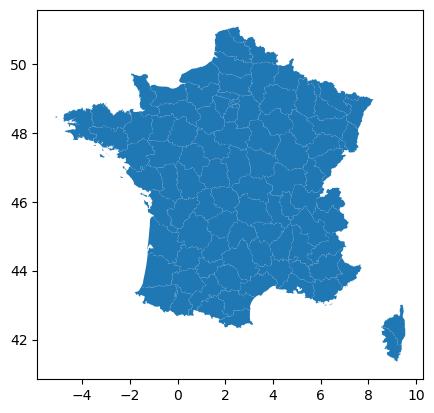

In [23]:
#Visualisation des contours
contours_dpt.plot()

On joint ensuite notre table départementale avec la table de contours départementaux. On note que les contours sont uniquement métropolitains et que la table obtenue ne concernera donc que les départements métropolitains. Etant donnée les défauts de données existant également pour la table nationale, on ne traitera que les département métropolitains.

In [24]:
#Préparation de la table 'contours_dpt'
contours_dpt = contours_dpt.rename(columns={'code': 'Département'})

print(contours_dpt)

   Département                      nom  \
0           01                      Ain   
1           02                    Aisne   
2           03                   Allier   
3           04  Alpes-de-Haute-Provence   
4           05             Hautes-Alpes   
..         ...                      ...   
91          91                  Essonne   
92          92           Hauts-de-Seine   
93          93        Seine-Saint-Denis   
94          94             Val-de-Marne   
95          95               Val-d'Oise   

                                             geometry  
0   POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1   POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2   POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...  
3   POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4   POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  
..                                                ...  
91  POLYGON ((2.22656 48.7761, 2.22866 48.77451, 2...  
92  POLYGON ((2.29097 48.95097, 2.2

In [25]:
# Inner join avec geopandas (gpd.merge)
dataframe_dep = dataframe.merge(
    contours_dpt,
    on=['Département'],
    how='inner'  # Conserve uniquement les lignes correspondantes
)

# Renommer les colonnes comme dans ton exemple
dataframe_dep = dataframe_dep.rename(columns={'geometry': 'Géométrie', 'nom': 'Nom'})

# Convertir en GeoDataFrame si nécessaire (si "contours_dpt" est déjà un GeoDataFrame, cette étape peut ne pas être nécessaire)
dataframe_dep = gpd.GeoDataFrame(dataframe_dep, geometry='Géométrie')

# Vérifier le résultat
print(dataframe_dep)


        Index                                      libellé index Département  \
0           1             Règlements de compte entre malfaiteurs          01   
1           2       Homicides pour voler et à l'occasion de vols          01   
2           3                     Homicides pour d'autres motifs          01   
3           4  Tentatives d'homicides pour voler et à l'occas...          01   
4           5          Tentatives homicides pour d'autres motifs          01   
...       ...                                                ...         ...   
277339    103  Infractions à l'exercice d'une profession règl...          95   
277340    104  Infractions au droit de l'urbanisme et de la c...          95   
277341    105                                   Fraudes fiscales          95   
277342    106            Autres délits économiques et financiers          95   
277343    107                                      Autres délits          95   

            Date  Nombre  Population   

### Calcul des taux de délinquance

''' 

https://mobile.interieur.gouv.fr/Interstats/Publications/Hors-collection/La-mesure-statistique-de-la-delinquance-AJ-Penal-Dalloz

https://www.interieur.gouv.fr/Media/SSMSI/Files/Interstats-Methode-N-3-La-premiere-generation-des-indicateurs-statistiques-des-crimes-et-delits-enregistres-par-la-police-et-la-gendarmerie-Octobre-2015/?nomobredirect=true

https://mobile.interieur.gouv.fr/Interstats/Actualites/Insecurite-et-delinquance-en-2023-bilan-statistique-et-atlas-departemental

'''

Les tableaux traités ici compote les 107 différentes catégories (index) d'infractions de "l'état 4001" enregistré par les forces de sécurité. De nature, fréquence et variables de comptage variées, agglomérer ces index en un seul indicateur de délinquance est susceptible de masquer des phénomènes délinquants important et en effet depuis 2012 le ministère de l'Intérieur a annoncé renoncé à l'utilisation d'indicateurs trop globaux. Aujourd'hui une dizaine d'indicateurs sont utilisés par le SSMSI dans leurs bilan statistique (le nombre peut varier selon la finesse de la typologie). On propose ici d'utiliser les 8 indicateurs principaux dénombrés dans le bilan statistique du SSMSI de 2013 ([téléchargable ici](https://mobile.interieur.gouv.fr/Interstats/Actualites/Insecurite-et-delinquance-en-2023-bilan-statistique-et-atlas-departemental)), à savoir les *homicides*, *tentatives d'homicides*, *coups et blessures volontaires*, *violences sexuelles*, *atteintes aux biens avec violence contre les personnes*, *atteintes aux biens sans violence contre les personnes*, *infractions à la législation sur les stupéfiants* et *escroqueries*.

Il est important de noter que les chiffres disponibles ici sont ceux de la criminalité observée et enregistrée qui reste un indicateur très imparfait. D'une part il n'est pas le nombre réel d'infractions mais n'est pas non plus égal à une proportion de ce nombre constante dans le temps. Des décisions politiques et de gestion (comme la politique du chiffre à partir de 2002, les variations de moyens alloués aux forces de sécurité) peuvent impacter la part de la criminalité enregistrée par rapport à la criminalité effective. D'autre part cette part observée n'est pas la même pour tous les types d'infractions. En particulier, les violences sexuelles étant très sous-déclarées et leur augmentation enregistrée étant quasiment uniquement dûe à la hausse des déclarations (au vue des enquêtes de victimation), on préférera  les traiter à part (ou ne pas les traiter par manque de temps).

Fort de ces remarques, on va dans cette section calculer les 8 indicateurs présentés à partir des 107 catégories à notre disposition. On utilise pour cela la section méthodologie du bilan de 2023 pour savoir quels index composent quelles catégories. On note que tous les index ne sont pas utilisés, certaines infractions ne correspondant pas ce qu'on considère usuellement comme phénomène délinquant (criminalité en col blanc, atteintes aux intérêts fondamentaux de la nation, fraude fiscale entre autres exemples).

In [26]:
# Mapping des indicateurs de délinquance et infractions associées 
mapping = {
    "Homicides": [1, 2, 3, 6, 51],
    "Tentatives d'homicides": [4, 5],
    "Coups et blessures volontaires": [7, 13],
    "Violences sexuelles": [45, 46, 47, 48, 49, 50],
    "Vols avec violence": [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    "Vols sans violence": [27, 28, 29, 30, 32, 42, 43, 34, 35, 36, 37, 38, 62, 63, 65, 66, 67, 68],
    "Stupéfiants": [56, 57, 58, 59],
    "Escroquerie": [91, 86, 89, 90, 92],
}

# Calcul des indicateurs et stockage dans les DateFrames

# Listes pour stocker les indicateurs
indicateurs_dep = []  # Niveau départemental
indicateurs_fr = []  # Niveau national

# Boucle qui permet de parcourir les DataFrames pour chaque indicateur
for indicateur, infractions in mapping.items():

    # On ne conserve que les lignes avec les infractions correspondant à l'indicateur
    dataframe_dep_filtre = dataframe_dep[dataframe_dep['Index'].isin(infractions)] 
    dataframe_nat_filtre = resultat[resultat['Index'].isin(infractions)] 

    # Somme des occurences d'infractions par zone géographique et par date
    somme_ind_dep = (dataframe_dep_filtre.groupby(["Date", "Département"])["Nombre"].sum()
        .reset_index() # Pour éviter que le groupby modifie l'index du DataFrame
    )
    somme_ind_nat = (dataframe_nat_filtre.groupby(["Date", "Zone"])["Nombre"].sum()
        .reset_index()
    )
    
    # Ajouter une colonne pour libeller les indicateurs
    somme_ind_dep["Indicateur"] = indicateur
    somme_ind_nat["Indicateur"] = indicateur

    # Ajouter les colonnes de libellé et de sommes au résultat
    indicateurs_dep.append(somme_ind_dep)
    indicateurs_fr.append(somme_ind_nat)

    # Population à date et zone géographique donnée 
    pop_dep_ind = (dataframe_dep_filtre.groupby(["Date", "Département"])["Population"].first())
    pop_nat_ind = (dataframe_nat_filtre.groupby(["Date", "Zone"])["Population"].first())

    # Contours géographiques à date et zone géographique donnée pour la base départementale
    geo_dep_ind = (dataframe_dep_filtre.groupby(["Date", "Département"])["Géométrie"].first())


# Combiner les résultats pour les indicateurs
df_indicateurs_dep = pd.concat(indicateurs_dep, ignore_index=True) 
df_indicateurs_nat = pd.concat(indicateurs_fr, ignore_index=True)

# Ajout des données de population départementale et les contours géographiques
df_indicateurs_dep = df_indicateurs_dep.merge(
    geo_dep_ind,
    on=["Date", "Département"],  
    how="left"                   
)

df_indicateurs_dep = df_indicateurs_dep.merge(
    pop_dep_ind,
    on=["Date", "Département"],  
    how="left"                   
)

df_indicateurs_nat = df_indicateurs_nat.merge(
    pop_nat_ind,
    on=["Date", "Zone"],  
    how="left"
)

# Réorganisation des colonnes 
df_indicateurs_dep = df_indicateurs_dep[["Date", "Département", "Indicateur", "Nombre", "Population", "Géométrie"]]
df_indicateurs_nat = df_indicateurs_nat[["Date", "Zone", "Indicateur", "Nombre", "Population"]]

# On supprime les lignes concernant la France Entière car nous avons trop de données manquantes sur ces zones
df_indicateurs_nat = df_indicateurs_nat.drop(df_indicateurs_nat[df_indicateurs_nat["Zone"] == "France_Entière"].index) 

# On crée une colonne avec les taux de délinquance pour chaque indicateurs en divisant les colonnes 'Nombre' et 'Population'
df_indicateurs_dep["Taux (%)"] = df_indicateurs_dep["Nombre"]*100/df_indicateurs_dep["Population"]

# On avait eu un problème pour la division au niveau national, on vérifie et corrige les problèmes de types de données
print(df_indicateurs_nat.dtypes)
df_indicateurs_nat["Population"] = pd.to_numeric(df_indicateurs_nat["Population"], errors='coerce')
print(df_indicateurs_nat.dtypes)

# On peut maintenant créer la colonne de taux dans la base de données nationale
df_indicateurs_nat["Taux (%)"] = df_indicateurs_nat["Nombre"]*100/df_indicateurs_nat["Population"]/1000 # La population est en milliers d'habitant

# Affichage les résultats
print(df_indicateurs_dep)
print(df_indicateurs_nat)

Date           object
Zone           object
Indicateur     object
Nombre        float64
Population     object
dtype: object
Date           object
Zone           object
Indicateur     object
Nombre        float64
Population      int64
dtype: object
           Date Département   Indicateur  Nombre  Population  \
0      _1996_01          01    Homicides     0.0      499310   
1      _1996_01          02    Homicides     1.0      538017   
2      _1996_01          03    Homicides     0.0      349376   
3      _1996_01          04    Homicides     0.0      137453   
4      _1996_01          05    Homicides     0.0      118526   
...         ...         ...          ...     ...         ...   
20731  _2022_01          91  Escroquerie   659.0     1319836   
20732  _2022_01          92  Escroquerie  1634.0     1641277   
20733  _2022_01          93  Escroquerie   898.0     1679240   
20734  _2022_01          94  Escroquerie   789.0     1421887   
20735  _2022_01          95  Escroquerie   686.0

On voulait sauvegarder les deux bases mais malheureusement elles sont trop volumineuses pour être push. Dommage...

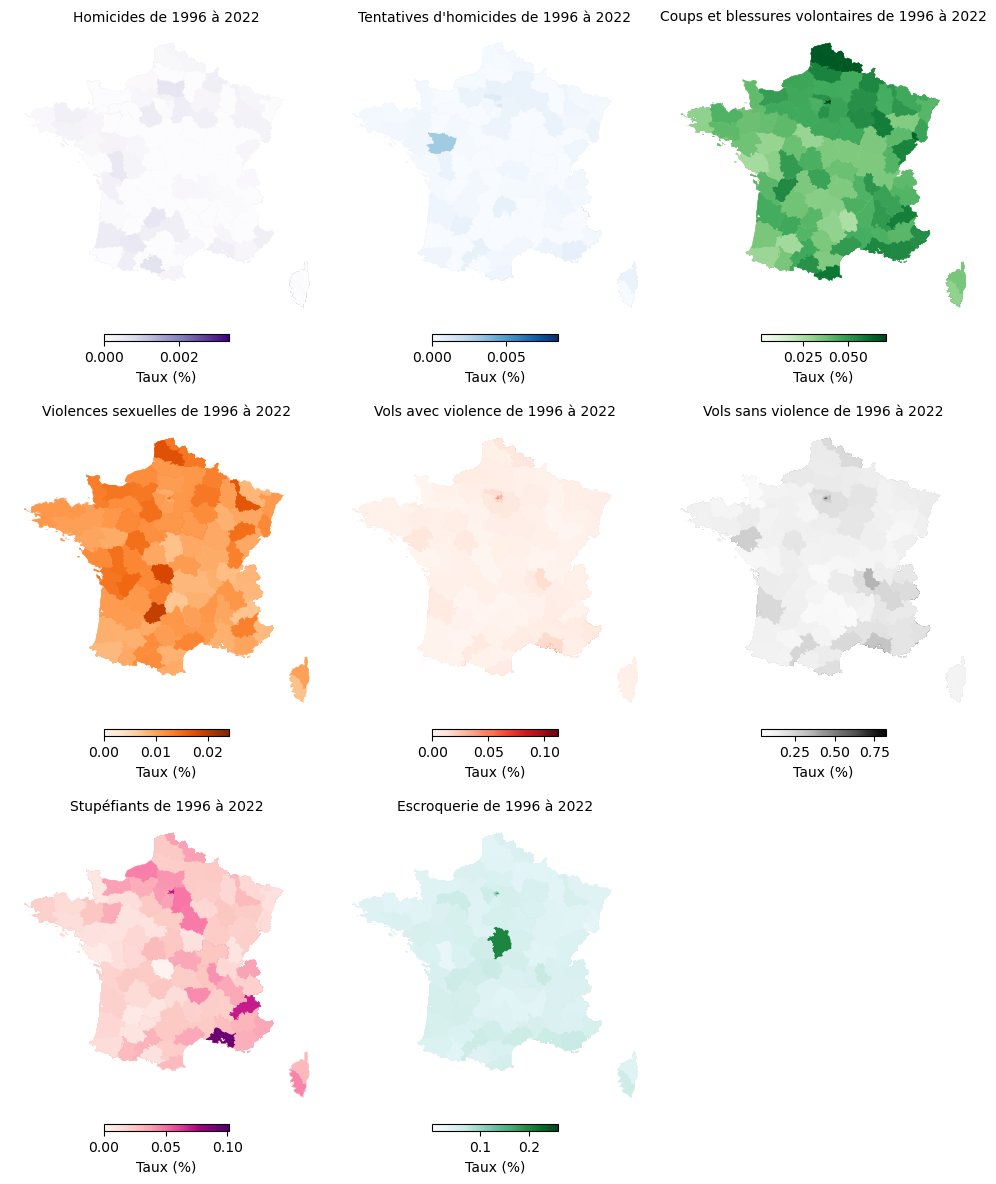

In [64]:
# Définir la colonne géométrique active
df_indicateurs_dep = df_indicateurs_dep.set_geometry("Géométrie")

indicateurs = list(mapping.keys())  

# Calcul du nombre total de figures
total_figures = len(indicateurs)

nuance = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'Greys', 'RdPu', 'BuGn']

# Créer des sous-graphiques
fig, axes = plt.subplots(3, 3, figsize=(10, 12))  # Augmenter la hauteur totale
axes = axes.flatten()

i = 0
for idx, indicateur in enumerate(indicateurs):
    # Tracer chaque indicateur
    df_indicateurs_dep[df_indicateurs_dep['Indicateur'] == indicateur].plot(
        column='Taux (%)',
        cmap=nuance[i],
        legend=True,
        ax=axes[idx],
        missing_kwds={"color": "lightgrey", "label": "Données manquantes"},
        legend_kwds={
            'shrink': 0.4,  
            'label': 'Taux (%)',  
            'orientation': 'horizontal',  
            'fraction': 0.04,  
            'pad': 0.04  
        }
    )

    # Ajuster le titre
    axes[idx].set_title(indicateur + " de 1996 à 2022", fontsize=10)
    axes[idx].axis('off')  # Masquer les axes

    # Ajuster le rapport d'aspect
    axes[idx].set_aspect(1.4)  # Étendre verticalement
    i += 1
    
# Supprimer les cadres inutilisés
for idx in range(total_figures, len(axes)):
    fig.delaxes(axes[idx])

# Ajuster les espacements
plt.tight_layout()
plt.show()


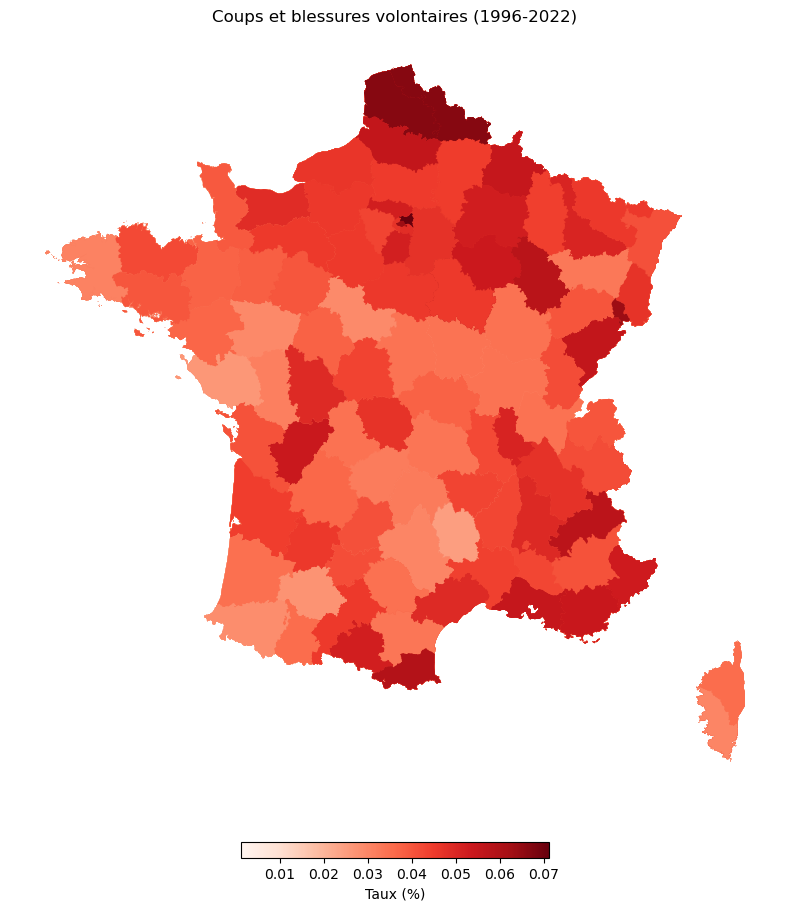

In [ ]:
# Définir la colonne géométrique active
df_indicateurs_dep = df_indicateurs_dep.set_geometry("Géométrie")

# Filtrer les données pour "Coups et blessures volontaires"
data_to_plot = df_indicateurs_dep[df_indicateurs_dep['Indicateur'] == "Coups et blessures volontaires"]

# Création de la carte
fig, ax = plt.subplots(1, 1, figsize=(8, 12))  # Ajuster figsize pour étirer verticalement

data_to_plot.plot(
    column='Taux (%)',
    cmap='Reds',  # Choix du dégradé
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "Données manquantes"},
    legend_kwds={
        'shrink': 0.4,  
        'label': 'Taux (%)',  
        'orientation': 'horizontal',  
        'fraction': 0.04,  
        'pad': 0.04  
    }
)

# Ajuster le rapport d'aspect (optionnel si figsize ne suffit pas)
ax.set_aspect(1.4)  # Ajuste le ratio pour étirer verticalement

# Ajouter un titre
ax.set_title("Coups et blessures volontaires (1996-2022)", fontsize=12)
ax.axis('off')  # Masquer les axes

# Afficher la carte
plt.tight_layout()
plt.show()

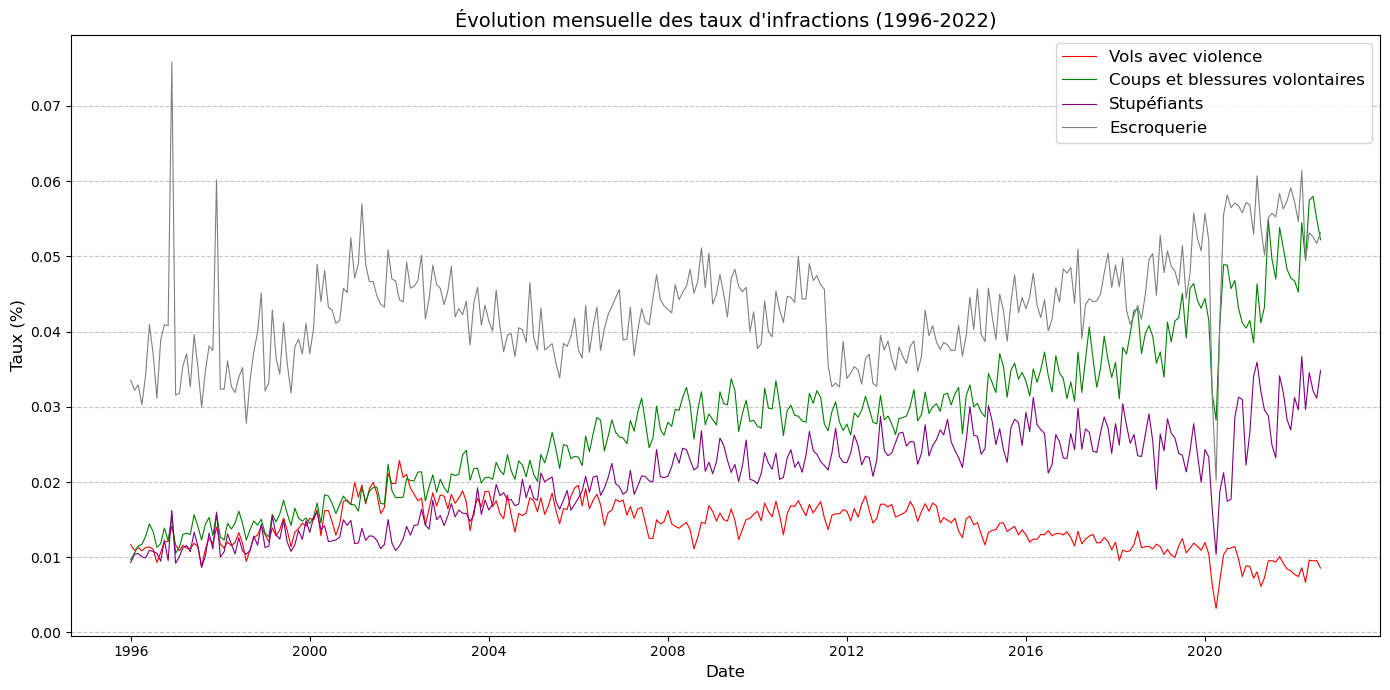

In [57]:
import matplotlib.pyplot as plt

# Filtrer les données pour le premier indicateur ("Vols avec violence")
filtre1 = df_indicateurs_nat['Indicateur'] == "Vols avec violence"
dates1 = pd.to_datetime(
    df_indicateurs_nat.loc[filtre1, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
    df_indicateurs_nat.loc[filtre1, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[1]
)
valeurs1 = df_indicateurs_nat.loc[filtre1, 'Taux (%)']

# Filtrer les données pour le deuxième indicateur ("Coups et blessures volontaires")
filtre2 = df_indicateurs_nat['Indicateur'] == "Coups et blessures volontaires"
dates2 = pd.to_datetime(
    df_indicateurs_nat.loc[filtre2, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
    df_indicateurs_nat.loc[filtre2, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[1]
)
valeurs2 = df_indicateurs_nat.loc[filtre2, 'Taux (%)']

# Filtrer les données pour le deuxième indicateur ("Stupéfiants")
filtre3 = df_indicateurs_nat['Indicateur'] == "Stupéfiants"
dates3 = pd.to_datetime(
    df_indicateurs_nat.loc[filtre3, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
    df_indicateurs_nat.loc[filtre3, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[1]
)
valeurs3 = df_indicateurs_nat.loc[filtre3, 'Taux (%)']

# Filtrer les données pour le deuxième indicateur ("Escroquerie")
filtre4 = df_indicateurs_nat['Indicateur'] == "Escroquerie"
dates4 = pd.to_datetime(
    df_indicateurs_nat.loc[filtre4, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
    df_indicateurs_nat.loc[filtre4, 'Date'].str.extract(r'_(\d{4})_(\d{2})')[1]
)
valeurs4 = df_indicateurs_nat.loc[filtre4, 'Taux (%)']

# Tracer les deux lignes
plt.figure(figsize=(14, 7))
plt.plot(dates1, valeurs1, color='Red', linewidth=0.8, label="Vols avec violence")
plt.plot(dates2, valeurs2, color='Green', linewidth=0.8, label="Coups et blessures volontaires")
plt.plot(dates3, valeurs3, color='Purple', linewidth=0.8, label="Stupéfiants")
plt.plot(dates4, valeurs4, color='Grey', linewidth=0.8, label="Escroquerie")

# Ajouter des titres et une légende
plt.title("Évolution mensuelle des taux d'infractions (1996-2022)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Taux (%)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage
plt.tight_layout()
plt.show()
